In [255]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass, field

import random
from operator import itemgetter

from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    mean_absolute_error,
)

import datetime as dt
from typing import List

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
# print('before sfmax: ',x.dim())
# print('before sfmax: ',x)
# x =torch.reshape(input=x, shape= (-1,x.shape[ndim-1]))
# actions = sfmax(x)

# print('after sfmax: ',actions.shape)
# print('after sfmax: ',actions)

In [280]:
class DeepQNetwork(nn.Module):
    def __init__(self, learning_rate, state_shape, action_shape, n_dense_1, n_dense_2):
        super(DeepQNetwork, self).__init__()
        self.layer_1 =  nn.Linear(state_shape, n_dense_1)
        self.bn1 = nn.BatchNorm1d(num_features=n_dense_1)
        self.layer_2 =  nn.Linear(n_dense_1, n_dense_2)
        self.layer_3 =  nn.Linear(n_dense_2, action_shape, dtype= torch.float32)
        self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate)
        self.cost_func = nn.CrossEntropyLoss()
        
    def forward(self, state):
        x = F.relu(self.layer_1(state))
        if x.dim()>1:
            x = self.bn1(x)
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        actions = F.softmax(x,dim=x.dim()-1)

        return actions

@dataclass
class RLModelWrapper:
    is_training:bool
    state_shape:int

    current_state_memory:list = field(default_factory=list)
    nxt_state_memory:list = field(default_factory=list)
    actions_taken_memory: list = field(default_factory=list)
    action_indexes_memory : list = field(default_factory=list)
    reward_memory:list = field(default_factory=list)
    iteration_done_bool_memory: list = field(default_factory=list)

    epsilon_min:float = 0.01
    epsilon_decay:float = 0.01
    ALPHA:float= 0.05
    learning_rate:float = 0.001
    DISCOUNT:float = 0.95
    cost_tracker:float = 0

    start_action: float = 0.05
    end_action: float = 2.0
    action_gap: float = 0.05

    batch_size:int = 80
    batch_start:int = 0
    batch_end:int = batch_size


    def __post_init__(self):
        self.EPSILON:float = 0.6 if self.is_training else 0
        self.agent_actions: list = list(np.arange(start=self.start_action,stop=self.end_action+self.action_gap,step=self.action_gap))
        self.n_actions: int = len(self.agent_actions)

        self.main_model: DeepQNetwork = DeepQNetwork(self.learning_rate,self.state_shape, self.n_actions, n_dense_1=100, n_dense_2=100)
        self.target_model: DeepQNetwork = DeepQNetwork(self.learning_rate,self.state_shape, self.n_actions, n_dense_1=100, n_dense_2=100)
        self.target_model.load_state_dict(self.main_model.state_dict())

    def store_data(self, curr_obs, nxt_obs, action, reward, done) -> None:
        self.current_state_memory.append(curr_obs)
        self.nxt_state_memory.append(nxt_obs)
        self.actions_taken_memory.append(action)
        self.action_indexes_memory.append(self.action_mapping(action, reversed= True))
        self.reward_memory.append(reward)

        done_val = 1 if done else 0
        self.iteration_done_bool_memory.append(done_val)

    def action_mapping(self,action_or_index , reversed = False) -> int | float: 
        if reversed:
            # if want to get action index by the specific action
            return self.agent_actions.index(action_or_index)
        else:
            #if want to get action by specific action index
            return self.agent_actions[action_or_index]

    def take_action(self,observation):
        if np.random.uniform() > self.EPSILON:
            encoded = observation
            predicted = self.main_model.forward(torch.tensor(encoded))
            action_index = np.argmax(predicted.tolist())
            return self.action_mapping(action_index)
        else:
            action_index = random.choice(range(self.n_actions))
            return self.action_mapping(action_index)
        

    def train(self):
        current_cost_tracker = 0
        MIN_REPLAY_SIZE = self.batch_end + self.batch_size
        if len(self.iteration_done_bool_memory) < MIN_REPLAY_SIZE:
            return
        else:
            batch_sample = random.sample(list(range(len(self.iteration_done_bool_memory))), self.batch_size)
            batch_indexes = list(range(self.batch_size))

            self.main_model.optimizer.zero_grad()
            curr_obs_batch = torch.tensor(itemgetter(*batch_sample)(self.current_state_memory), dtype= torch.float32)
            nxt_obs_batch  = torch.tensor(itemgetter(*batch_sample)(self.nxt_state_memory), dtype= torch.float32)
            actions_indexes_batch = itemgetter(*batch_sample)(self.action_indexes_memory)
            rewards_batch = torch.tensor(itemgetter(*batch_sample)(self.reward_memory), dtype= torch.float32)
            dones_batch = itemgetter(*batch_sample)(self.iteration_done_bool_memory)  # [0,0,0,1]
            not_dones_batch = torch.tensor(np.ones(len(dones_batch))-dones_batch, dtype= torch.float32) # [1,1,1,0]
            
            curr_qs_batch = self.main_model.forward(curr_obs_batch)[batch_indexes, actions_indexes_batch]
            nxt_qs_batch = self.target_model.forward(nxt_obs_batch)

            q_target = torch.add(rewards_batch,not_dones_batch*self.DISCOUNT*torch.max(nxt_qs_batch, dim=1)[0])
            # changed_q = curr_qs_batch + ALPHA * (q_target - curr_qs_batch)
            cost = self.main_model.cost_func(curr_qs_batch, q_target)
            current_cost_tracker+=cost
            cost.backward()
            self.main_model.optimizer.step()

            self.batch_start = self.batch_end
            self.batch_end += self.batch_size
            self.cost_tracker = current_cost_tracker


In [312]:
# make the starting state of the environment to be the 1st value of the training data
# create a function to calculate reward using the next state predicted by RL and the actual value
#   -make the reward as (1-smape value)*100, which gives the approx percentage accuracy
# define the input state observations:  lagged series, action taken


@dataclass
class HotelEnv:
    train_df: pd.DataFrame = pd.read_csv('train_df.csv')
    n_training_dates: int = len(train_df)
    observed_n_lags: int = 30
    current_data_arry: np.typing.NDArray = np.array([],dtype='float32')
    timestep: int = 0

    def __post_init__(self):
        self.observation_cols = [f'lag_{i}' for i in range(1,self.observed_n_lags+1)]

    def step(self,action):
        new_data_arry = self.current_data_arry
        weekly_lags = [i for i in range(7,self.observed_n_lags,7)]
        RL_predicted_value = np.mean(new_data_arry[weekly_lags]*action)
        
        reward = self.get_reward(RL_predicted_value)

        #after appending new predicted value to the start of arry considering the relevant lags for the next observation
        new_data_arry = np.append(RL_predicted_value, new_data_arry)[:self.observed_n_lags]
        self.current_data_arry = new_data_arry
        next_state = np.array(np.append(new_data_arry,action), dtype='float32')

        self.timestep+=1
        done=True if self.timestep>=(self.n_training_dates-1) else False

        return next_state,reward,done

    def reset(self) -> np.typing.NDArray:
        self.timestep=0
        #getting the 1st lagged series as a start
        data_arry = self.train_df.iloc[self.timestep][self.observation_cols].to_numpy(dtype='float32')
        self.current_data_arry= data_arry

        #appending dummy starting action.(which means multiplying the latest lag_1 value with 1, but isnt doing anything here)
        data_arry = np.array(np.append(data_arry, 1), dtype='float32')
        return data_arry
    
    def get_reward(self, pred_value) -> float:
        actual_value = self.train_df.iloc[self.timestep]['lag_0']
        smape = mean_absolute_percentage_error(y_pred=[pred_value] ,y_true=[actual_value],symmetric=True)
        mae = mean_absolute_error(y_pred=[pred_value] ,y_true=[actual_value])
        if smape>1:
            smape=1

        #returning the percentage accuracy  
        return np.round((1-smape)*100)

In [292]:
# is_training = True

# hotel_env = HotelEnv()
# model = RLModelWrapper(state_shape = 31,is_training=is_training)
# total_reward = []

# steps_to_update_models = 0
# total_epi_reward = 0    
# observation = hotel_env.reset()

# done = False

# steps_to_update_models += 1
# model.EPSILON=0
# RL_action = model.take_action(observation)
# next_state,reward,done = hotel_env.step(RL_action)

# model.store_data(observation, next_state, RL_action, reward, done)

In [313]:
n_episodes = 500
is_training = True

hotel_env = HotelEnv(observed_n_lags=60)

model = RLModelWrapper(state_shape = 61,is_training=is_training)
total_reward = []
epsilon_values = []


for episode in range(1,n_episodes+1):
        steps_to_update_models = 0
        total_epi_reward = 0    
        observation = hotel_env.reset()

        done = False
        while not done:
                steps_to_update_models += 1

                RL_action = model.take_action(observation)
                next_state,reward,done = hotel_env.step(RL_action)

                model.store_data(observation, next_state, RL_action, reward, done)

                total_epi_reward+=reward
                observation = next_state

                if (steps_to_update_models % 4 == 0 or done) and is_training:
                        model.train()
                        
                if (steps_to_update_models % 10 == 0) and is_training:
                        model.target_model.load_state_dict(model.main_model.state_dict())

        eps_decay_start_day = int(hotel_env.n_training_dates- (2/(0.0001*n_episodes) ))  if n_episodes>=3 else 60
        if (hotel_env.timestep > eps_decay_start_day) and (model.EPSILON > model.epsilon_min) and (episode%30==0):
                model.EPSILON-= model.epsilon_decay
        print(f'episode : {episode} reward : {total_epi_reward/steps_to_update_models} ,cost : {model.cost_tracker}, epsilon : {model.EPSILON}')
     
# if is_training:
#       torch.save(model.main_model.state_dict(), 'models\model.pkl')
    


episode : 1 reward : 19.997275204359674 ,cost : 8432.6416015625, epsilon : 0.6
episode : 2 reward : 20.17983651226158 ,cost : 6920.0966796875, epsilon : 0.6
episode : 3 reward : 30.04632152588556 ,cost : 8847.48828125, epsilon : 0.6
episode : 4 reward : 31.8283378746594 ,cost : 9204.1669921875, epsilon : 0.6
episode : 5 reward : 33.58855585831063 ,cost : 7957.837890625, epsilon : 0.6
episode : 6 reward : 35.3732970027248 ,cost : 8931.8017578125, epsilon : 0.6
episode : 7 reward : 33.787465940054496 ,cost : 10639.7939453125, epsilon : 0.6
episode : 8 reward : 35.65122615803815 ,cost : 9260.8212890625, epsilon : 0.6
episode : 9 reward : 36.52861035422343 ,cost : 11995.056640625, epsilon : 0.6
episode : 10 reward : 34.53405994550409 ,cost : 10324.060546875, epsilon : 0.6
episode : 11 reward : 33.59400544959128 ,cost : 12382.109375, epsilon : 0.6
episode : 12 reward : 38.00544959128065 ,cost : 12385.572265625, epsilon : 0.6
episode : 13 reward : 30.752043596730246 ,cost : 9908.423828125, e

**Testing predictions - 1 day ahead forecasts to test**

In [314]:
test_df = pd.read_csv('test_df.csv').reset_index(drop=True).drop('Unnamed: 0',axis=1)
test_df['arrival_date'] = pd.to_datetime(test_df['arrival_date'])

In [315]:
pred_dct = {'arrival_date':[], 'lag_0':[], 'pred':[], 'RL_action':[]}

model.EPSILON=0

for i in range(len(test_df)):
    actual_value =test_df.iloc[i]['lag_0']
    observation = test_df.iloc[i][hotel_env.observation_cols].to_numpy(dtype='float32')
    if i==0:
        RL_action = 1
    observation = np.array(np.append(observation,RL_action), dtype='float32')

    RL_action = model.take_action(observation)
    pred = observation[0]*RL_action
    pred_dct['arrival_date'].append(test_df.iloc[i]['arrival_date'])
    pred_dct['lag_0'].append(actual_value)
    pred_dct['pred'].append(pred)
    pred_dct['RL_action'].append(RL_action)




In [316]:
pred_df = pd.DataFrame(pred_dct)
pred_df['arrival_date'] = pd.to_datetime(pred_df['arrival_date'])

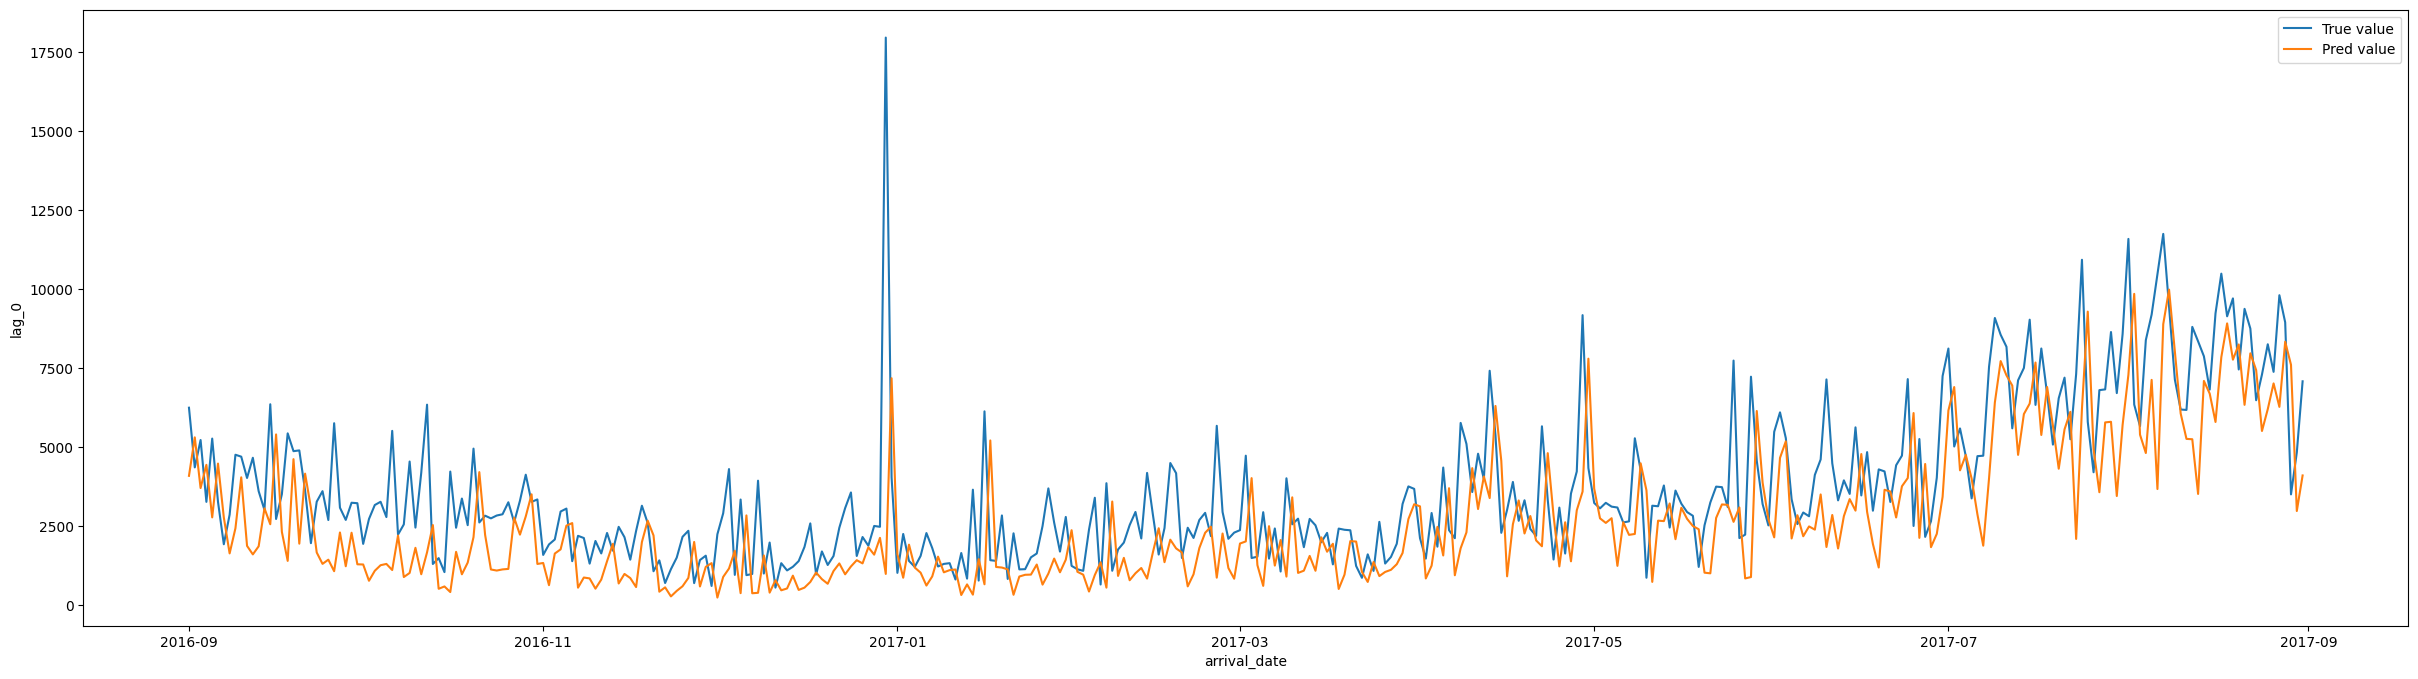

In [317]:
plt.figure(figsize=(30,8))
sns.lineplot(data=pred_df, x = 'arrival_date', y='lag_0', label='True value')
sns.lineplot(data=pred_df, x = 'arrival_date', y='pred', label='Pred value')
plt.legend()

In [321]:
print(pred_df.RL_action.value_counts())
print('SMAPE:',mean_absolute_percentage_error(y_pred=pred_df['pred'], y_true=pred_df['lag_0'], symmetric=True))
print('MAE:',mean_absolute_error(y_pred=pred_df['pred'], y_true=pred_df['lag_0']))


display_cols =['arrival_date', 'lag_0', 'pred']+[f'lag_{i}' for i in range(7,30,7)]
merged_df = pred_df.merge(test_df.drop('lag_0', axis=1), on='arrival_date',how='inner')[display_cols]
merged_df

RL_action
0.85    235
0.40    130
Name: count, dtype: int64
SMAPE: 0.5650225479856958
MAE: 1579.5154624006718


,arrival_date,lag_0,pred,lag_7,lag_14,lag_21,lag_28
0,2016-09-01,6255.86,4099.278149,4881.32,8858.81,8501.63,8223.93
1,2016-09-02,4366.89,5317.480884,7262.00,5942.81,9312.95,6946.98
2,2016-09-03,5232.95,3711.856616,8060.77,9011.40,9947.77,7263.46
3,2016-09-04,3275.52,4448.007666,6750.51,5759.21,6388.15,7547.96
4,2016-09-05,5278.86,2784.192017,6514.03,11466.58,10590.25,10928.63
...,...,...,...,...,...,...,...
360,2017-08-27,9816.47,6282.681616,7466.87,8357.05,10472.70,6718.36
361,2017-08-28,8957.56,8343.999268,9385.54,7884.60,11757.66,8588.15
362,2017-08-29,3512.50,7613.925635,8760.71,6829.13,9463.91,11599.05
363,2017-08-30,4837.43,2985.625000,6492.58,9243.21,7145.05,6355.10


In [326]:
print('SMAPE:',mean_absolute_percentage_error(y_pred=merged_df[[f'lag_{i}' for i in range(7,30,7)]].mean(axis=1), y_true=pred_df['lag_0'], symmetric=True))
print('MAE:',mean_absolute_error(y_pred=merged_df[[f'lag_{i}' for i in range(7,30,7)]].mean(axis=1), y_true=pred_df['lag_0']))

SMAPE: 0.3565835057574843
MAE: 1288.0435479452055


**Base model to compare - LightGBM regressor**

In [264]:
## training a base model
train_data = pd.read_csv('train_df.csv').drop('Unnamed: 0',axis=1)
x_cols = [f'lag_{i}' for i in range(1,30+1)]
y_col = 'lag_0'

model = LGBMRegressor(objective='regression', verbose=-1)
model.fit(X=train_data[x_cols], y=train_data[y_col])


LGBMRegressor(objective='regression', verbose=-1)

In [271]:
lgbm_pred_df = test_df[['arrival_date','lag_0']]

lgbm_pred_df['pred_lgbm'] = model.predict(X=test_df[x_cols])

print('SMAPE: ',mean_absolute_percentage_error(y_pred=lgbm_pred_df['pred_lgbm'], y_true=lgbm_pred_df['lag_0'], symmetric=True))
print('MAE:',mean_absolute_error(y_pred=lgbm_pred_df['pred_lgbm'], y_true=lgbm_pred_df['lag_0']))

SMAPE:  0.34587657398842925
MAE: 1157.2261123637231


C:\Users\sanja\AppData\Local\Temp\ipykernel_17708\2546986385.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lgbm_pred_df['pred_lgbm'] = model.predict(X=test_df[x_cols])


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

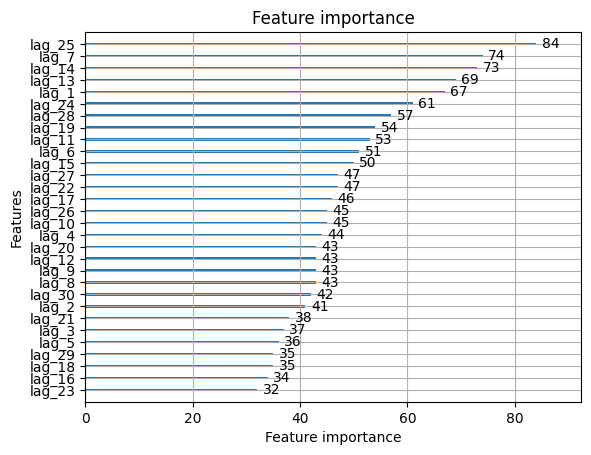

In [268]:
lgb.plot_importance(model)

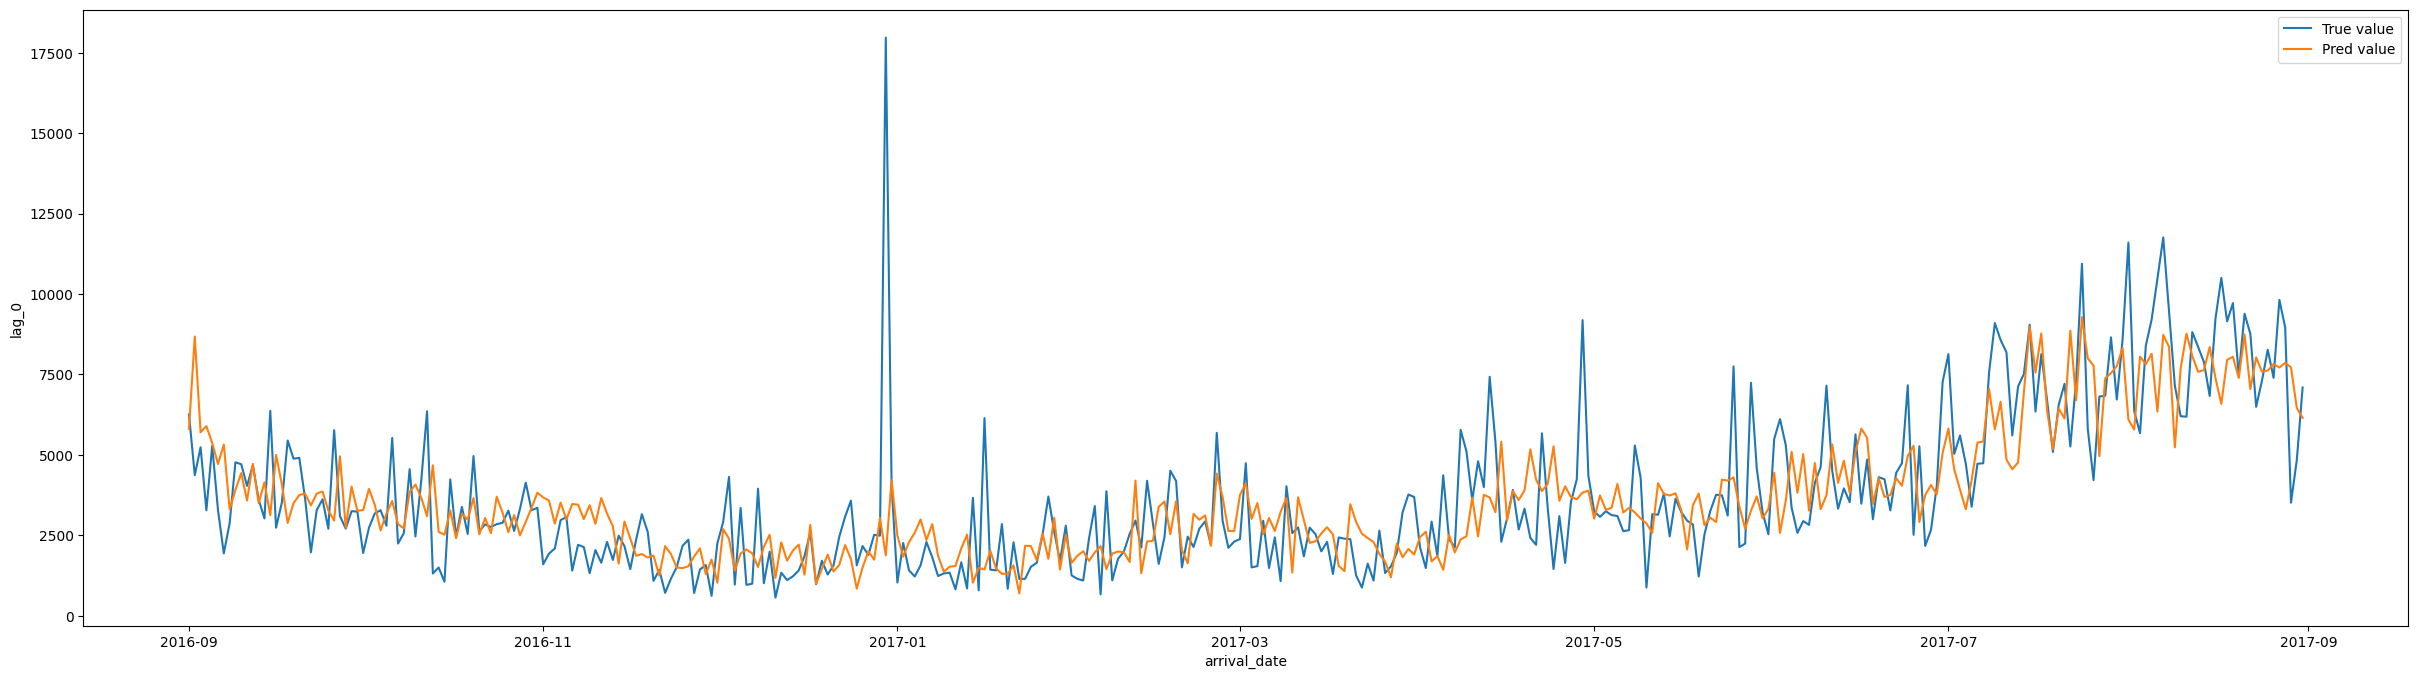

In [269]:
plt.figure(figsize=(30,8))
sns.lineplot(data=lgbm_pred_df, x = 'arrival_date', y='lag_0', label='True value')
sns.lineplot(data=lgbm_pred_df, x = 'arrival_date', y='pred_lgbm', label='Pred value')
plt.legend()